# **ResNet50**

## **Imports**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, 
                             precision_score, f1_score, classification_report)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, clear_output
from tensorflow.keras import layers

## **Parse TFR**

In [2]:
def parse_tfr(proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    rec = tf.io.parse_single_example(proto, feature_description)
    image = tf.image.decode_jpeg(rec['image'], channels=3)
    label = rec['label']
    return image, label

train_file = 'data/oversampled_train_images.tfrecords'
val_file = 'data/preprocessed_val_images.tfrecords'
test_file = 'data/preprocessed_test_images.tfrecords'

train_dataset = tf.data.TFRecordDataset(train_file)
train_dataset = train_dataset.map(parse_tfr)

val_dataset = tf.data.TFRecordDataset(val_file)
val_dataset = val_dataset.map(parse_tfr)

test_dataset = tf.data.TFRecordDataset(test_file)
test_dataset = test_dataset.map(parse_tfr)


In [3]:
num_train_examples = sum(1 for _ in train_dataset)
num_val_examples = sum(1 for _ in val_dataset)
num_test_examples = sum(1 for _ in test_dataset)

print(f">> Number of examples in the training dataset: {num_train_examples}")
print(f">> Number of examples in the validation dataset: {num_val_examples}")
print(f">> Number of examples in the test dataset: {num_test_examples}")

>> Number of examples in the training dataset: 4464
>> Number of examples in the validation dataset: 1280
>> Number of examples in the test dataset: 1


## **Helper Functions**

In [4]:
class CustomLearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self):
        super(CustomLearningRateSchedule, self).__init__()

    def __call__(self, step):
        learning_rate = tf.cond(step < 5, lambda: 0.001, lambda: tf.cond(step < 10, lambda: 0.0001, lambda: 0.00001))
        return learning_rate


def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochen")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric])
        ax[idx].legend(['train_' + metric, 'val_' + metric])
        ax[idx].grid(True) 
        ax[idx].set_title(f'{metric.capitalize()}')

    plt.tight_layout()
    plt.show()

def validate(model, val_dataset, class_names=None):
    val_labels = []
    predictions = []

    for image, label in val_dataset:
        val_labels.append(label.numpy())
        prediction = model.predict(image)  
        predictions.append(prediction)

    val_labels = np.array(val_labels)
    predictions = np.vstack(predictions)

    predicted_labels = np.argmax(predictions, axis=1)

    # Flatten batched arrays to ensure equal length
    val_labels = val_labels.flatten()
    predicted_labels = predicted_labels.flatten()

    confusion = confusion_matrix(val_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate overall metrics
    overall_metrics_df = pd.DataFrame({
        "Metric": ["Accuracy", "Weighted Recall", "Weighted Precision", "Weighted F1 Score"],
        "Value": [
            accuracy_score(val_labels, predicted_labels),
            recall_score(val_labels, predicted_labels, average='weighted'),
            precision_score(val_labels, predicted_labels, average='weighted'),
            f1_score(val_labels, predicted_labels, average='weighted')
        ]
    })

    print("Overall Metrics:")
    print(overall_metrics_df)
    print("\n")

    print("Classification Report (Validation):")
    print(classification_report(val_labels, predicted_labels, target_names=class_names))


def visualize_predictions(model, dataset, class_names, num_images=20, image_size=(3, 3), fontsize=8):
    images = []
    true_labels = []
    predicted_labels = []

    for i, (image, label) in enumerate(dataset):
        if i >= num_images:
            break
        images.append(image.numpy())
        true_labels.append(class_names[label.numpy()[0]])

        prediction = model.predict(np.expand_dims(image, axis=0))

        predicted_label = class_names[np.argmax(prediction)]
        predicted_labels.append(predicted_label)

    num_rows = int(np.ceil(num_images / 4))
    fig, axes = plt.subplots(num_rows, 4, figsize=(image_size[0] * 4, image_size[1] * num_rows))

    for i, (image, true_label, predicted_label) in enumerate(zip(images, true_labels, predicted_labels)):
        ax = axes[i // 4, i % 4]
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}", fontsize=fontsize)

    for i in range(num_images, num_rows * 4):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    display(plt.gcf())
    clear_output(wait=True)

## **Train ResNet50** 

**Apply Batch Size**

In [5]:
BATCH_SIZE = 4

RS50_train_data = train_dataset.batch(BATCH_SIZE)
RS50_val_data = val_dataset.batch(BATCH_SIZE)

**Load ResNet50 Model**

In [6]:
tf.keras.datasets.cifar10.load_data()

((array([[[[ 59,  62,  63],
           [ 43,  46,  45],
           [ 50,  48,  43],
           ...,
           [158, 132, 108],
           [152, 125, 102],
           [148, 124, 103]],
  
          [[ 16,  20,  20],
           [  0,   0,   0],
           [ 18,   8,   0],
           ...,
           [123,  88,  55],
           [119,  83,  50],
           [122,  87,  57]],
  
          [[ 25,  24,  21],
           [ 16,   7,   0],
           [ 49,  27,   8],
           ...,
           [118,  84,  50],
           [120,  84,  50],
           [109,  73,  42]],
  
          ...,
  
          [[208, 170,  96],
           [201, 153,  34],
           [198, 161,  26],
           ...,
           [160, 133,  70],
           [ 56,  31,   7],
           [ 53,  34,  20]],
  
          [[180, 139,  96],
           [173, 123,  42],
           [186, 144,  30],
           ...,
           [184, 148,  94],
           [ 97,  62,  34],
           [ 83,  53,  34]],
  
          [[177, 144, 116],
           [16

**Create Model**

In [7]:
input_t = tf.keras.Input(shape=	(300, 300, 3))
res_model = tf.keras.applications.ResNet50(include_top=False,
                                           weights="imagenet",
                                           input_tensor=input_t)

model = tf.keras.models.Sequential([
    res_model,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),  # Reduzierte Anzahl von Neuronen
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')  # Ausgabeschicht für 4 Klassen
])

lr_schedule = CustomLearningRateSchedule()

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])

**Train Model**

Running the model took 27 Minutes

Highest Accuracy: 98%
Highest Val. Accuracy: 98%


Playing with learning rate changes how fast the model converges but also influences overfitting usw.

In [8]:
history = model.fit(RS50_train_data, batch_size=BATCH_SIZE, epochs=6, verbose=1, validation_data=RS50_val_data, #callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)]
                    )

Epoch 1/6
1116/1116 [==============================] - 145s 125ms/step - loss: 1.9113 - accuracy: 0.5923 - val_loss: 0.7851 - val_accuracy: 0.7633
Epoch 2/6
1116/1116 [==============================] - 146s 131ms/step - loss: 0.4722 - accuracy: 0.8226 - val_loss: 0.5872 - val_accuracy: 0.8508
Epoch 3/6
1116/1116 [==============================] - 145s 130ms/step - loss: 0.1750 - accuracy: 0.9393 - val_loss: 0.6278 - val_accuracy: 0.8562
Epoch 4/6
1116/1116 [==============================] - 145s 130ms/step - loss: 0.0741 - accuracy: 0.9756 - val_loss: 0.5482 - val_accuracy: 0.8945
Epoch 5/6
1116/1116 [==============================] - 146s 131ms/step - loss: 0.0447 - accuracy: 0.9854 - val_loss: 0.3123 - val_accuracy: 0.9266
Epoch 6/6
1116/1116 [==============================] - 147s 131ms/step - loss: 0.0233 - accuracy: 0.9924 - val_loss: 0.2304 - val_accuracy: 0.9555


**Plot**

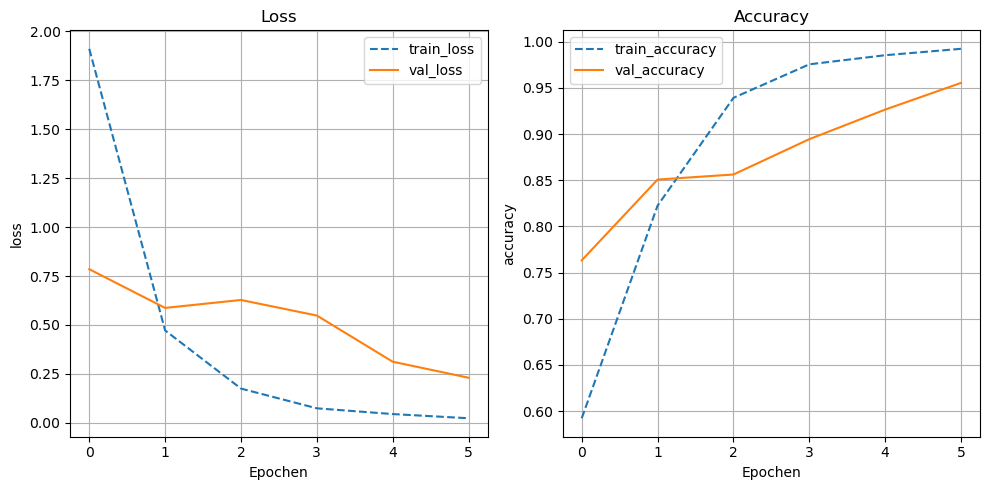

In [9]:
training_plot(["loss", "accuracy"], history)

**Validation on Test dataset**

check the model with data which it has never seen. Best practice is to do it not on validation data, beacause validation data leakage could blend results

1/1 [==============================] - 0s 23ms/step


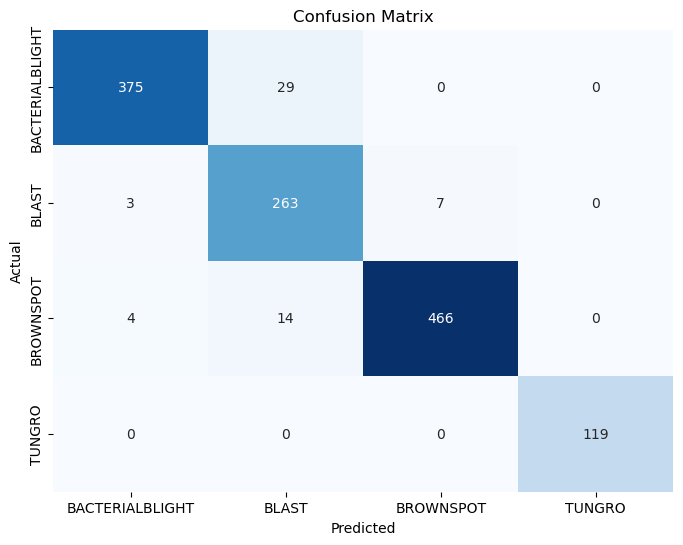

Overall Metrics:
               Metric     Value
0            Accuracy  0.955469
1     Weighted Recall  0.955469
2  Weighted Precision  0.958649
3   Weighted F1 Score  0.956143


Classification Report (Validation):
                 precision    recall  f1-score   support

BACTERIALBLIGHT       0.98      0.93      0.95       404
          BLAST       0.86      0.96      0.91       273
      BROWNSPOT       0.99      0.96      0.97       484
         TUNGRO       1.00      1.00      1.00       119

       accuracy                           0.96      1280
      macro avg       0.96      0.96      0.96      1280
   weighted avg       0.96      0.96      0.96      1280



In [10]:
validate(model, RS50_val_data, class_names=["BACTERIALBLIGHT", "BLAST", "BROWNSPOT", "TUNGRO"])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dropout (Dropout)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 64)                13107264  
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 36,695,236
Trainable params: 36,642,116
No

**Prediction**

In [12]:
visualize_predictions(model, val_dataset, class_names=["BACTERIALBLIGHT", "BLAST", "BROWNSPOT", "TUNGRO"], num_images=8, image_size=(3, 3), fontsize=10)

IndexError: invalid index to scalar variable.